In [1]:
from utils.data_preparation import *
from utils.data_exploration import *

from rdkit import Chem

import pandas as pd

task = 'CYP2C19'

## Loading the Dataset + Data Cleaning

In terms of data cleaning the following steps are performed:

- Normalization of smiles strings before calculating descriptors and fingerprints
  - Normalization includes the removal of metals in the molecule (<span style="color:cyan">TODO</span> Why?)
- Removal of small molecules
  - For example: 
    - Molecules consisting of a single atom (<span style="color:cyan">TODO</span> Why?)
    - Molecules that are metals
- *Molecular Descriptors:* Removing of NaN values by either removing the corresponding column or row. 
  - For molecular descriptors it doesn't make much sense to fill missing values with some default value or mean of the existing values

In [2]:
data = data_preprocessing(task)
data = remove_small_molecules(data)

Dataset already exists, returning data/cyp2c19/raw_dataset_descriptors.csv.
3765     OCCCSCCO
4313       CCCCNN
4416     NCC(O)CN
5075    NNC(NN)NN
5489      CC(N)=O
5501       N#CCCN
5507    NOCC(=O)O
5546    CC(=O)NBr
5665    CCSC(=N)N
5711     NC(=O)NO
5715           NO
5755        [Cl-]
5785     CSC(=N)N
5799         NCCS
5846            N
5856       NCCCCN
5900     NNC(N)=O
6040       N#[O+]
6766    NCCC(=O)O
6767    NCCS(=O)O
6772     NCC(=O)O
6994    Nc1ccncc1
7321        NNNNN
Removing the following molecules: 
Series([], )


### Remove missing values 

In [3]:
data_nan = extract_null(data)
print(
    f"There are {data_nan.shape[0]} ({data_nan.shape[0]/data.shape[0]*100:.2f}%) many molecules and {data_nan.shape[1]-3} descriptors with missing values."
)
data_nan

There are 35 (0.28%) many molecules and 12 descriptors with missing values.


,Drug,Drug_ID,Y,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
3855,O=[As](O)(O)c1ccc([As](=O)(O)O)cc1,224250.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3856,O=S(=O)(Nc1nccs1)c1ccc([As](=O)(O)O)cc1,224267.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3857,O=C(O)CNC(=O)c1ccc([As](=O)(O)O)cc1,224270.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3858,O=[As](O)(O)c1ccc(N=Nc2ccc(O)cc2)cc1,224279.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3859,NC(=O)c1ccc(C(=O)Nc2ccc([As](=O)(O)O)cc2)cc1,224295.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3863,NC(=O)Nc1cc([As](=O)(O)O)cc(I)c1O,224575.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3879,NS(=O)(=O)Cc1ccc([As](=O)(O)O)cc1,224907.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3880,O=C(O)[C@@H](O)c1ccc([As](=O)(O)O)cc1,3246047.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3881,O=S(=O)(NCCO)c1ccc([Sb](=O)(O)O)cc1,224913.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3882,O=C(O)/C=C\c1cccc([Sb](=O)(O)O)c1,5771529.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since only 0.28% of molecules have missing values we simply remove those molecules. Using a default value or similar doesn't make sense for the given descriptors, PartialCharge and BCUT2D. <span style="color:cyan">TODO</span> Add description ad PartialCharge and BCUT2D.

In [4]:
summarize_descriptors(data_nan.columns[3:])

{'MaxPartialCharge': 'N/A',
 'MinPartialCharge': 'N/A',
 'MaxAbsPartialCharge': 'N/A',
 'MinAbsPartialCharge': 'N/A',
 'BCUT2D_MWHI': 'N/A',
 'BCUT2D_MWLOW': 'N/A',
 'BCUT2D_CHGHI': 'N/A',
 'BCUT2D_CHGLO': 'N/A',
 'BCUT2D_LOGPHI': 'N/A',
 'BCUT2D_LOGPLOW': 'N/A',
 'BCUT2D_MRHI': 'N/A',
 'BCUT2D_MRLOW': 'N/A'}

In [5]:
# split data in train, val, test
datasets = dataset_split(data)
datasets["train"]

,Y,Drug,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
683,0,Cc1cnc(CNc2cc(-c3ccc(N(C)C)cc3)ncn2)cn1,3232975.0,4.358067,0.572719,4.358067,0.572719,0.779486,320.400,300.240,...,0,0,0,0,0,0,0,0,0,0
4901,1,Oc1ccc(CCNCc2cc3c(cc2Br)OCO3)cc1,290548.0,9.241427,0.291178,9.241427,0.291178,0.813449,350.212,334.084,...,0,0,0,0,0,0,0,0,1,0
9962,1,COc1ccccc1N1CCN(C(=O)/C=C/c2ccc3c(c2)OCO3)CC1,1148765.0,12.511429,0.020688,12.511429,0.020688,0.779132,366.417,344.241,...,0,0,0,0,0,0,0,0,0,0
4411,0,C[C@@H]1CC[C@H]2[C@H](C)[C@H]3[C@H](C[C@H]4[C@...,3246286.0,11.797286,-0.163887,11.797286,0.085032,0.569371,413.646,370.302,...,0,0,0,0,0,0,0,0,0,0
6500,0,CCN1C[C@]2(C)CC[C@H](O)[C@]34[C@@H]1[C@@H](C[C...,6604400.0,12.145411,-0.857731,12.145411,0.065698,0.675534,377.525,342.245,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5141,0,Cc1ccc2c(c1)N[C@H](c1ccc(C(=O)O)cc1)c1cccn1-2,3246630.0,11.026955,-0.905094,11.026955,0.001986,0.752170,304.349,288.221,...,0,0,0,0,0,0,0,0,0,0
3811,0,O=C(O)/C=C(\CC(=O)O)C(=O)O,444212.0,10.175509,-1.541852,10.175509,0.357593,0.497668,174.108,168.060,...,0,0,0,0,0,0,0,0,0,0
11018,1,O=C1CCN(S(=O)(=O)c2ccccc2)N1,1487853.0,11.891204,-3.570231,11.891204,0.187222,0.778091,226.257,216.177,...,0,1,0,0,0,0,0,0,0,0
3450,1,CC(C)(CC(=O)N1CCN(c2ccc(Cl)cc2)CC1)CC1=NS(=O)(...,3242845.0,12.980420,-3.731463,12.980420,0.074466,0.707613,475.014,447.798,...,0,1,0,0,0,0,0,0,0,0


## Dataset Exoploration

In [6]:
datasets["train"].describe()

,Y,Drug_ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,8865.000000,8.865000e+03,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,...,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000,8865.000000
mean,0.455274,6.116419e+06,11.292623,-0.861617,11.292623,0.196325,0.614092,352.516603,332.495324,352.127510,...,0.108855,0.077383,0.013085,0.004061,0.011619,0.033277,0.000226,0.065651,0.118331,0.044670
std,0.498024,1.763093e+07,2.679036,1.451632,2.679036,0.227071,0.188021,105.253759,99.815491,105.138875,...,0.333175,0.276753,0.115614,0.063599,0.109253,0.193877,0.015019,0.255312,0.748108,0.213042
min,0.000000,1.080000e+02,0.000000,-7.603763,0.000000,0.000000,0.034058,17.031000,14.007000,17.026549,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.326381e+06,10.979539,-1.020923,10.979539,0.046375,0.486410,290.706000,273.634000,290.174276,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.234023e+06,12.263696,-0.391626,12.263696,0.121918,0.630778,346.467000,326.268000,346.146347,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,4.108328e+06,12.911008,-0.059994,12.911008,0.241378,0.772189,406.482000,384.266000,406.068867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.460310e+08,17.398044,3.500000,17.398044,3.811700,0.946895,1664.922000,1579.242000,1663.492352,...,4.000000,2.000000,2.000000,1.000000,2.000000,4.000000,1.000000,2.000000,26.000000,3.000000


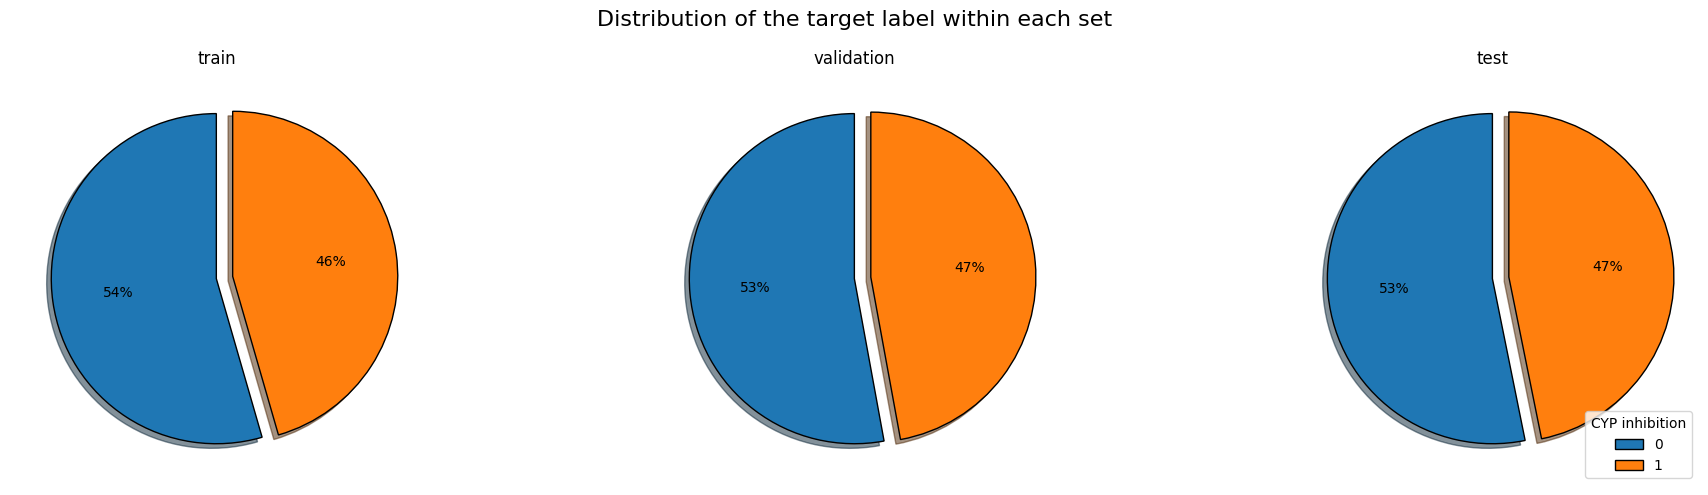

In [7]:
plot_counts(
    [datasets["train"]["Y"], datasets["val"]["Y"], datasets["test"]["Y"]],
    suptitle="Distribution of the target label within each set",
    titles=["train", "validation", "test"],
    legend_title="CYP inhibition",
    kind="pie",
)